In [ ]:
%matplotlib inline


Introduction to Image Classification
=====================

To begin with, let's use the pretrained models for solving two main CV tasks: Image Classification and Image Segmentation.

We are going to use an image of these cute pets. 

In [ ]:
from PIL import Image

import requests
from io import BytesIO
url = "https://images.unsplash.com/photo-1573435567032-ff5982925350?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1974&q=80"
img = Image.open((requests.get(url, stream=True).raw))
img 

We will use the [Pipeline](https://huggingface.co/docs/transformers/v4.21.2/en/main_classes/pipelines#transformers.pipeline) class, provided by an awesome [Hugginface Transformers](https://huggingface.co/docs/transformers/index) library. 

In [ ]:
#image classification
from transformers import pipeline
#if we do not specify model id google/vit-base-patch16-224 will be used by default
clf = pipeline("image-classification")
clf(img)

The results are pretty good - indeed, there's a cat in the image. But you may notice, that the model is pretty confused about the output (top 2 class outputs have very similar score values) - we will discuss this topic a bit later in our course. However, in the case when two (or more) different objects are presented in the image, the simpliest thing to do is to perform an image segmentation.  

In [ ]:
model = pipeline("image-segmentation")
rez = model(img)
rez

Let's visualize the results!

In [ ]:
import numpy as np
#dog
img2 = rez[5]['mask'].convert('RGB')
ni = Image.blend(img2, img, 0.5)
ni

In [ ]:
import numpy as np
#cat
img2 = rez[6]['mask'].convert('RGB')
ni = Image.blend(img2, img, 0.5)
ni

Image Classification from scratch
==========

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import os
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

#for reproducibility 
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, there's a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

We will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip()
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#val split
train_data, val_data = train_test_split(trainset, test_size=0.25, random_state=42)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')

Let us show some of the training images.



In [ ]:
# settings
nrows, ncols = 3, 4  # array of sub-plots
figsize = [8, 8]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    image, label = trainset[i]
    img = image / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    axi.imshow(npimg)
    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    axi.set_title(f"label: {classes[label]}")


2. Define a Convolutional Neural Network




In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

In [ ]:
model = Net()

3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize. 

In [ ]:
def train_fn(train_loader, model, criterion, optimizer, epoch, device):
    losses = AverageMeter()
    # switch to train mode
    model.train()
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1000)
        optimizer.step()
        optimizer.zero_grad()
        
        if step % 100 == 0 or step == (len(valid_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step, len(train_loader), loss=losses,
                   grad_norm=grad_norm,
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    gt_labels = []
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        gt_labels.append(labels.to('cpu').numpy())
        if step % 100 == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader),
                   loss=losses,
                   ))
    predictions = np.concatenate(preds)
    gt_labels = np.concatenate(gt_labels)
    return losses.avg, predictions, gt_labels


def inference_func(model, testloader, device):
    correct = 0
    total = 0
    model.eval()
    preds = []
    gt_labels = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    for step, (images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network 
        with torch.no_grad():
            outputs = model(images)
        preds.append(outputs.softmax(1).to('cpu').numpy().argmax(1))
        gt_labels.append(labels.to('cpu').numpy())
    predictions = np.concatenate(preds)
    gt_labels = np.concatenate(gt_labels)
    return predictions, gt_labels

In [ ]:
model.to(device)
for epoch in range(10):  # loop over the dataset multiple times
    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, device)
    # eval
    avg_val_loss, preds, val_labels = valid_fn(valid_loader, model, criterion, device)
    acc_score = accuracy_score(val_labels, preds.argmax(1))
    print(f"Validation accuracy for epoch {epoch} is {acc_score:.2f}")
    
print('Finished Training')

Let's quickly save our trained model:



In [ ]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

5. Test the network on the test data


We have trained the network for 10 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. 

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [ ]:
model = Net()
model.load_state_dict(torch.load(PATH))
model.to(device)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



Let us look at how the network performs on the whole dataset.



In [ ]:
preds, labels = inference_func(model, testloader, device)
acc = accuracy_score(labels, preds)
print(f'Accuracy of the network trained from scratch on the {len(testset)} test images: {acc:.2f}%')

That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Let's plot a confusionn matrix for our model.

In [ ]:
cl_labels = [classes[l] for l in labels]
cl_preds = [classes[l] for l in preds]

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_predictions(cl_labels, cl_preds, ax=ax, normalize='true')
plt.show()

Transfer learning
==========

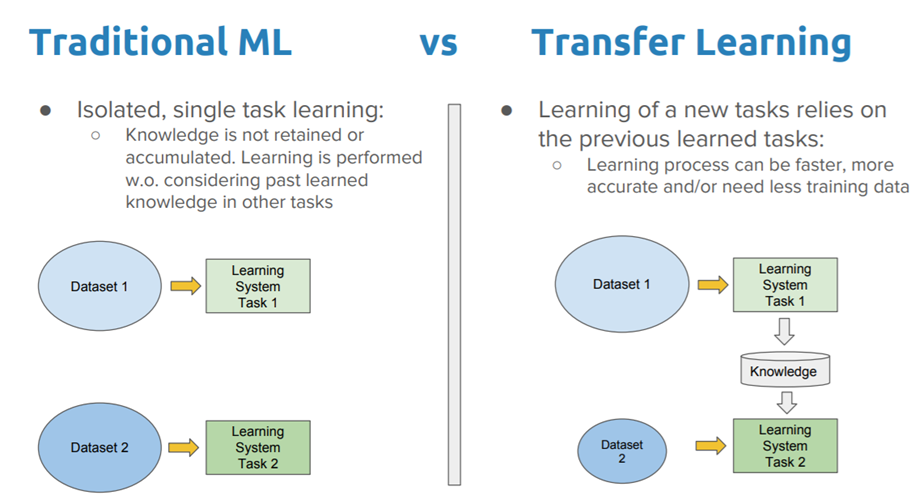

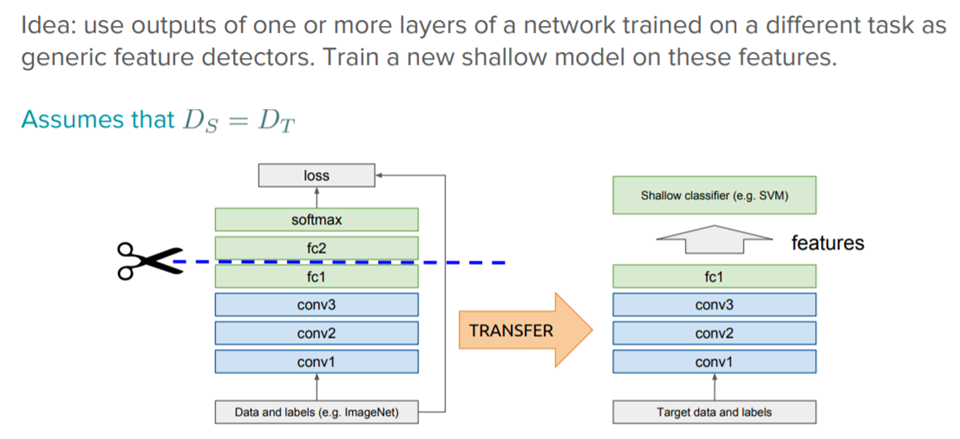

Let's try to use a bit more complicated model for our task. From now on we'll deal with a ResNet model https://arxiv.org/abs/1512.03385

Instead of manually implementing the model architecture, we'll use architeectures, provided by [timm](https://github.com/rwightman/pytorch-image-models) library. 

In [ ]:
import timm

class ResNet(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, 10)

    def forward(self, x):
        x = self.model(x)
        return x

Let's check the performance of a ResNet, initialized with random weights, on the Cifar10 dataset. 

In [ ]:
model = ResNet(pretrained=False)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

model.to(device)
for epoch in range(10):  # loop over the dataset multiple times
    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, device)
    # eval
    avg_val_loss, preds, val_labels = valid_fn(valid_loader, model, criterion, device)
    acc_score = accuracy_score(val_labels, preds.argmax(1))
    print(f"Validation accuracy for epoch {epoch} is {acc_score:.2f}")
    
print('Finished Training')


In [ ]:
preds, labels = inference_func(model, testloader, device)
acc = accuracy_score(labels, preds)
print(f'Accuracy of the network trained from scratch on the {len(testset)} test images: {acc:.2f}%')

And now, we'll load the pretrained weights.

In [ ]:
model = ResNet(pretrained=True)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

model.to(device)
for epoch in range(3):  # loop over the dataset multiple times
    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, device)
    # eval
    avg_val_loss, preds, val_labels = valid_fn(valid_loader, model, criterion, device)
    acc_score = accuracy_score(val_labels, preds.argmax(1))
    print(f"Validation accuracy for epoch {epoch} is {acc_score:.2f}")
    
print('Finished Training')

In [ ]:
preds, labels = inference_func(model, testloader, device)
acc = accuracy_score(labels, preds)
print(f'Accuracy of the pretrained network on the {len(testset)} test images: {acc:.2f}%')

Data Augmentation
=========

The best way to improve the performance of a machine learning model is to train it on more data. The more examples the model has to learn from, the better it will be able to recognize which differences in images matter and which do not. More data helps the model to generalize better.

One easy way of getting more data is to use the data you already have. If we can transform the images in our dataset in ways that preserve the class, we can teach our classifier to ignore those kinds of transformations. For instance, whether a car is facing left or right in a photo doesn't change the fact that it is a Car and not a Truck. So, if we augment our training data with flipped images, our classifier will learn that "left or right" is a difference it should ignore.

And that's the whole idea behind data augmentation: add in some extra fake data that looks reasonably like the real data and your classifier will improve.

In [ ]:
import albumentations as A

pillow_image = img
image = np.array(pillow_image)

In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2, **kwargs):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def visualize_titles(img, bbox, title, color=BOX_COLOR, thickness=2, font_thickness = 2, font_scale=0.35, **kwargs):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    ((text_width, text_height), _) = cv2.getTextSize(title, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, title, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, TEXT_COLOR,
                font_thickness, lineType=cv2.LINE_AA)
    return img


def augment_and_show(aug, image, mask=None, bboxes=[], categories=[], category_id_to_name=[], filename=None, 
                     font_scale_orig=0.35, font_scale_aug=0.35, show_title=True, **kwargs):

    augmented = aug(image=image, category_id=categories)
    image_aug = augmented['image']
    
    f, ax = plt.subplots(1, 2, figsize=(16, 8))

    ax[0].imshow(image)
    ax[0].set_title('Original image')

    ax[1].imshow(image_aug)
    ax[1].set_title('Augmented image')

    f.tight_layout()

    if filename is not None:
        f.savefig(filename)
        
    return augmented['image']

light = A.Compose([
    A.RandomBrightnessContrast(p=1),    
    A.RandomGamma(p=1),    
    A.CLAHE(p=1),
], p=1)

medium = A.Compose([
    A.CLAHE(p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1),
], p=1)


strong = A.Compose([
    A.ChannelShuffle(p=1),
    A.Transpose(p=1),
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
    A.ShiftScaleRotate(p=1),
    A.CoarseDropout(p=1),
    A.Cutout(p=1, max_h_size=200, max_w_size=200)
], p=1)

In [ ]:
r = augment_and_show(light, image)

In [ ]:
r = augment_and_show(medium, image)

In [ ]:
r = augment_and_show(strong, image)

Image classification with Hugginface Transformers
=============

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cifar10")
model_checkpoint = "microsoft/resnet-18"

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
    
    
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

In [ ]:
#define augmentations
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

#different augmentations are used for training and validation
def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["img"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["img"]]
    return example_batch

In [ ]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.2)
train_ds = splits['train']
val_ds = splits['test']
test_ds = dataset['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_val)

In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-cifar",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    overwrite_output_dir=True,
)

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()

In [ ]:
results = trainer.evaluate(test_ds)
results